# Anoxic Event Group
OOI Data Labs Workshop - March 2019

**Working Title**: The impact of interaction between the mid-depth ocean and coastal waters on fisheries

**Short Description**: Explore the relationship between atmospheric processes (wind), oceanic processes (currents and upwelling) and how these processes affect benthic organisms and our ability to fish for them.

**Your Objective** (Challenge Question): How do changing weather conditions and ocean circulation patterns affect our ability to fish for benthic organisms like crabs?



In [0]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4
import matplotlib.pyplot as plt

    100% |████████████████████████████████| 3.9MB 7.2MB/s 
    100% |████████████████████████████████| 307kB 27.6MB/s 


## Request Data from OOINet

* **Wind data**: Oregon Shelf Surface Mooring, Surface Buoy, Bulk Meteorological Instrument Package (CE02SHSM-SBD11-06-METBKA000) recovered_host
* **Dissolved oxygen**: Oregon Inshore Surface Mooring, Seafloor Multi-function Mode (MFN), Dissolved Oxygen (CE01ISSM-MFD37-03-DOSTAD000) recovered_inst
* **Temperature**: Oregon Inshore Surface Mooring, Seafloor Multi-function Mode (MFN), (CE01ISSM-MFD37-03-CTDBPC000) recovered_inst
* Dissolved oxygen profile from shelf edge/slope station, if possible

In [0]:
def request_data(reference_designator,method,stream,start_date,end_date):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'beginDT':start_date,
    'endDT':end_date,
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# # Met Data
# request_data('CE02SHSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')

# # DO Data
# request_data('CE01ISSM-MFD37-03-DOSTAD000','recovered_inst','dosta_abcdjm_ctdbp_instrument_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')

# # Temperature Data
# request_data('CE01ISSM-MFD37-03-CTDBPC000','recovered_inst','ctdbp_cdef_instrument_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')


## Load Datasets

In [0]:
# Resultant Dataset Directories
url_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190327T192845-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_do = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190327T193104-CE01ISSM-MFD37-03-DOSTAD000-recovered_inst-dosta_abcdjm_ctdbp_instrument_recovered/catalog.html'
url_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190327T193404-CE01ISSM-MFD37-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'


In [0]:
def get_data(url,bad_inst=''):
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  # ds = ds.chunk({'time': 100}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
data_met = get_data(url_met,'velpt')
data_do = get_data(url_do,'CTDBPC000')
data_ctd = get_data(url_ctd)

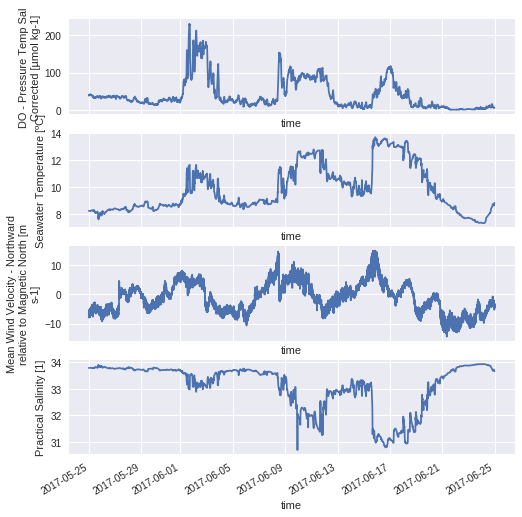

In [0]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(8,8))
data_do.dissolved_oxygen.plot(ax=ax1)
data_ctd.ctdbp_seawater_temperature.plot(ax=ax2)
data_met.northward_wind_velocity.plot(ax=ax3)
data_ctd.practical_salinity.plot(ax=ax4);

# Add 0 line for wind
# Convert DO to mg/L
# Add 2 line for DO

In [0]:
# Other variables?
# data_met.air_temperature.plot()
# data_met.barometric_pressure.plot()
# data_met.longwave_irradiance.plot()
# data_ctd.practical_salinity.plot()
# data_ctd.pressure.plot()

## Merge and export

In [0]:
# Resample/average to 15 minutes
avgint = '1h' #'15min'
a = data_do['dissolved_oxygen'].load().resample(time=avgint).mean()
b = data_ctd['ctdbp_seawater_temperature'].load().resample(time=avgint).mean()
c = data_met['northward_wind_velocity'].load().resample(time=avgint).mean()
d = data_ctd['practical_salinity'].load().resample(time=avgint).mean()

In [0]:
# Merge the datasets
x = xr.merge([a,b,c,d]).to_dataframe()
x.head()

,dissolved_oxygen,ctdbp_seawater_temperature,northward_wind_velocity,practical_salinity
time,,,,
2017-05-25 00:00:00,39.305817,8.264365,-6.759833,33.786660
2017-05-25 01:00:00,40.351552,8.246202,-6.364333,33.791832
2017-05-25 02:00:00,41.026466,8.238258,-6.194167,33.793758
2017-05-25 03:00:00,40.320287,8.260391,-5.834000,33.789965
2017-05-25 04:00:00,40.450829,8.286342,-5.266667,33.784464


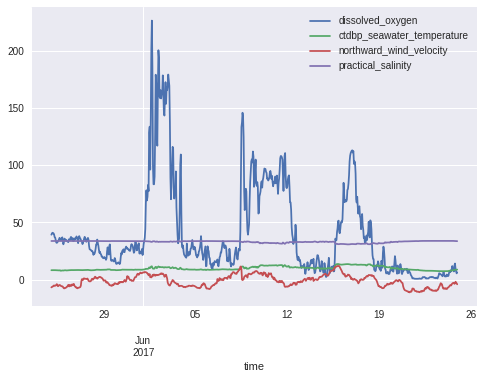

In [0]:
x.plot();

In [0]:
# Export to CSV
x.to_csv('anoxia2017.csv')